In [9]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test, inference_detector, init_detector, show_result_pyplot
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import matplotlib.pyplot as plt 
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import cv2

In [10]:
# pip install pyshine
import pyshine as ps

In [11]:
def get_dicts_with_key_value(my_list, key, value):
    return [d for d in my_list if d.get(key) == value]


In [12]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='../../dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/faster_rcnn_r50_fpn_1x_coco_trash'

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [13]:
# build dataset & dataloader

dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [14]:
checkpoint = os.path.join(cfg.work_dir, f'{epoch}.pth')

device='cuda:0'
cfg.model.pretrained = None

# Initialize the detector
model = build_detector(cfg.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)
model.CLASSES = dataset.CLASSES

model.cfg = cfg
model.to(device)
model.eval()

load checkpoint from local path: ./work_dirs/faster_rcnn_r50_fpn_1x_coco_trash/latest.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [107]:
def show_img_gt_pred(model,dataset_path,image_num):

    while len(str(image_num)) != 4:
        image_num = '0'+ str(image_num)
    
    # load an image and its corresponding ground truth annotation
    img = mmcv.imread(f'{dataset_path}/train/{image_num}.jpg')
    ann_file = f'{dataset_path}/train.json'
    mid_path = f'{dataset_path}/vis_mid_result'
    final_path = f'{dataset_path}/vis_final_result'

    os.makedirs(mid_path, exist_ok=True)
    os.makedirs(final_path, exist_ok=True)

    ########## draw pred ##########
    # Use the detector to do inference
    result = inference_detector(model, img)

    # save pred image
    model.show_result(img, result, 
                    score_thr=0.7, bbox_color=(0,0,255), # predict color : blue
                    thickness=2,font_size=8,
                    out_file= f'{mid_path}/{image_num}.jpg')
    
    ########## draw gt ##########
    # load annotations
    gt_ann = mmcv.load(ann_file)['annotations']
    gt_ann = get_dicts_with_key_value(gt_ann, 'image_id', int(image_num))

    # get bbox list
    gt_bbox_list = []
    for gt in gt_ann:
        gt_bbox_list.append(gt['bbox'])
    
    gt_bbox_list = np.array(gt_bbox_list).astype(np.int32)

    # get label list
    gt_label_list = []
    for gt in gt_ann:
        gt_label_list.append(gt['category_id'])

    img_pred = mmcv.imread(f'{mid_path}/{image_num}.jpg')

    for i in range(len(gt_bbox_list)):
        
        # change bbox type -> np.int32
        bbox = gt_bbox_list[i].astype(np.int32)

        # draw GT bbox
        cv2.rectangle(img_pred, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 0, 255), 2)

        # put text
        img_pred = ps.putBText(img_pred,'GT_'+dataset.CLASSES[gt_label_list[i]],text_offset_x= bbox[0],text_offset_y=bbox[1] + bbox[3] + np.int(5),vspace=5,hspace=5, font_scale=0.7,background_RGB=(0,0,0),text_RGB=(255,0,0))
        
    img = cv2.cvtColor(img_pred,cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,10))

    save_path = os.path.join(final_path, f'{image_num}.png')
    plt.imsave(save_path,img)
    plt.imshow(img)
    

/opt/conda/envs/myenv1/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


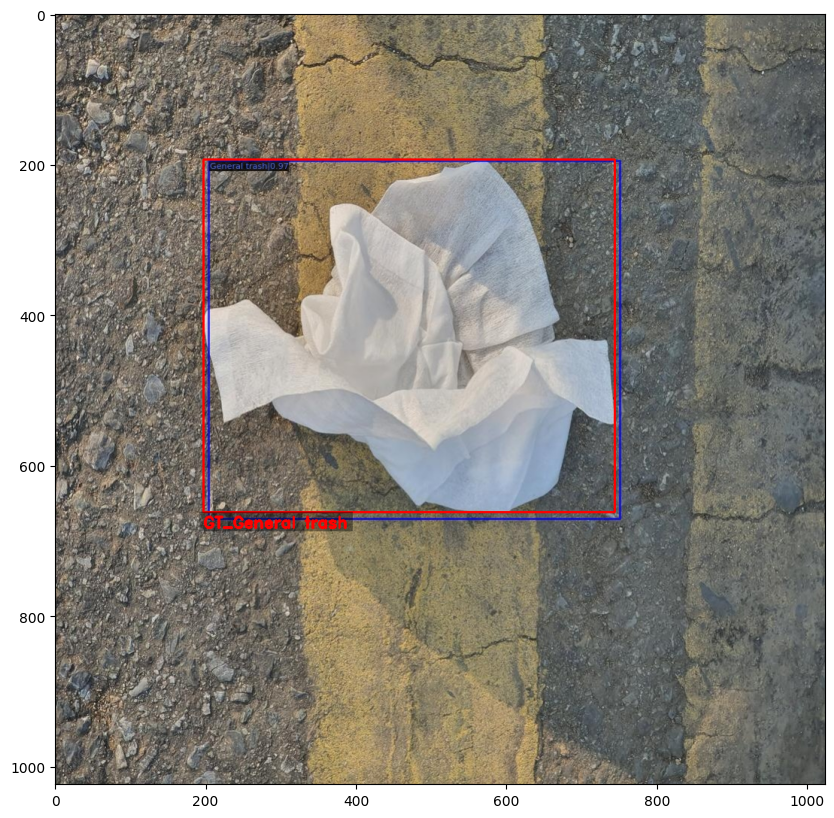

In [108]:
dataset_path = '/opt/ml/dataset'

# image_num의 경우 앞의 0은 빼고 입력해줘야 합니다.
# ex) 0006 -> 6, 0283 -> 283
show_img_gt_pred(model,dataset_path,0)